### Khởi tạo post_df và replies_df

In [1]:
import pandas as pd
import numpy as np
import json 
from dateutil.parser import isoparser

posts_df = pd.read_csv(r"C:\Users\DELL Pre 7670\Downloads\cleaned_posts.csv")
replies_df = pd.read_csv(r'C:\Users\DELL Pre 7670\Downloads\cleaned_replies.csv')

### Phân tích nội dung thuần


#### 1. Sử dụng `wordcloud` để biễu diễn cơ bản về những `keyword` sẽ xuất hiện trong bài đăng của người dùng.


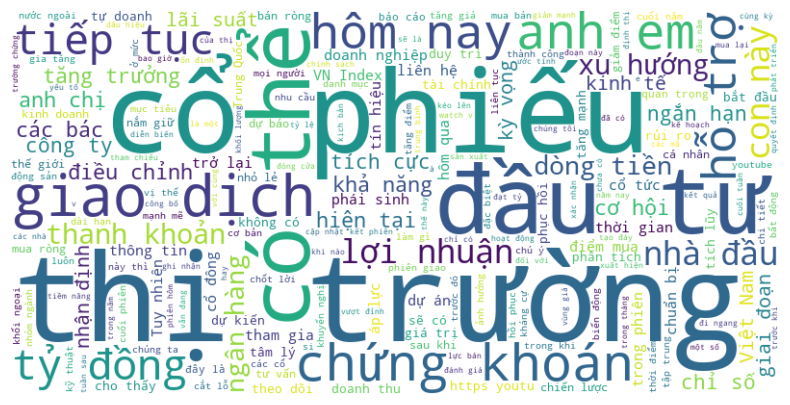

In [2]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Kết hợp tất cả văn bản từ cột 'originalContent'
text = " ".join(content for content in posts_df.originalContent)

# Tạo wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Nhận xét:
- Ngoài `cổ phiếu`, `giao dịch`, `thị trường` thì có 1 số keyword đáng chú ý là `thanh khoản`, `điểm mua`, `kỳ vọng` là những keyword đáng chú ý.

#### 2. Đặt vấn đề về những đường link có xuất hiện trong nội dung của các bài viết. 

Để phân tích ta sẽ sử dụng thư viện `re` để tìm các đường link trong cột `originalContent` của dataframe `posts_df`.

In [3]:

import re

# Tìm tất cả các đường link trong cột 'originalContent'
posts_df['links'] = posts_df['originalContent'].apply(lambda x: re.findall(r'(https?://\S+)', x))

# Chuyển sentiment từ dạng số sang string
posts_df['sentiment'] = posts_df['sentiment'].astype('string')
posts_df['sentiment'] = posts_df['sentiment'].replace({'1': 'positive', '0': 'neutral', '-1': 'negative'})

# Tạo một dataframe mới chỉ chứa các bài viết có đường link
links_df = posts_df.explode('links')[['date', 'postID', 'links', 'sentiment']].dropna().reset_index(drop=True)

links_df
# Trích xuất loại links từ cột 'links'
links_df['links'] = links_df['links'].apply(lambda x: x.replace('youtu.be', 'youtube.com') if 'youtu.be' in x else x)
links_df['link_type'] = links_df['links'].apply(lambda x: re.search(r'https?://(?:www\.)?([^/]+)', x).group(1) if re.search(r'https?://(?:www\.)?([^/]+)', x) else None)

links_df


,date,postID,links,sentiment,link_type
0,2024-11-06T21:38:45.743+07:00,29104016,https://www.youtube.com/live/rfLkHPX-CJo?si=5x...,neutral,youtube.com
1,2024-11-06T21:38:26.107+07:00,29104004,https://chungkhoannhatrang.vn/khanh-hoa-ban-ha...,neutral,chungkhoannhatrang.vn
2,2024-11-06T21:35:57.05+07:00,29103932,https://youtube.com/shorts/rH3OON8pU2A?si=8wCa...,neutral,youtube.com
3,2024-11-06T21:33:38.58+07:00,29103860,https://www.youtube.com/watch?v=5Aj7jDO1VSY&t=11s,positive,youtube.com
4,2024-11-06T21:28:34.473+07:00,29103739,https://youtube.com/clip/UgkxkjaCQ0bGfS64zvuSt...,neutral,youtube.com
...,...,...,...,...,...
10648,2024-09-06T10:17:02.76+07:00,28009227,https://youtube.com/live/aIB78pZQilg?feature=s...,neutral,youtube.com
10649,2024-09-06T10:14:16.993+07:00,28009092,https://f247.com/t/hpg-cho-doi-lan-gio-chinh-s...,neutral,f247.com
10650,2024-09-06T10:12:48.367+07:00,28009016,https://youtube.com/wERiDcK2BNA?si=aa3TpE65HYR...,neutral,youtube.com
10651,2024-09-06T10:11:00.183+07:00,28008910,https://f247.com/t/vn-index-dung-de-nghi-ngo-l...,neutral,f247.com


Mã trên sẽ tạo một dataframe `links_df` chứa các đường link và mã bài viết tương ứng.

C:\Users\DELL Pre 7670\AppData\Local\Temp\ipykernel_524\812844030.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_links['probability'] = top_10_links['count'] / top_10_links['count'].sum() * 100


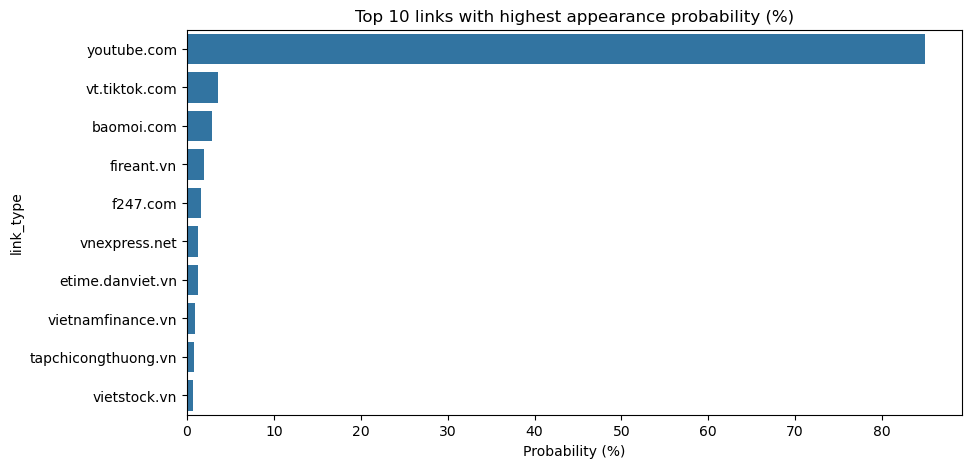

In [4]:
import seaborn as sns

# Lập bảng thống kê số lượng links theo loại
link_type_counts = links_df['link_type'].value_counts().reset_index()
link_type_counts.columns = ['link_type', 'count']
link_type_counts


# Lập chart biểu diễn 10 links có xác suất xuất hiện cao nhất
top_10_links = link_type_counts.head(10)
top_10_links['probability'] = top_10_links['count'] / top_10_links['count'].sum() * 100
plt.figure(figsize=(10, 5))
sns.barplot(x='probability', y='link_type', data=top_10_links)
plt.title('Top 10 links with highest appearance probability (%)')
plt.xlabel('Probability (%)')
plt.show()

Nhận xét:
- Có thể thấy rằng đa số các liên kết trong bài viết đều dẫn đến các trang web bên ngoài, trong đó có nhiều liên kết đến `youtube.com`.
- Vậy ta có thể kết luận rằng người dùng thường chia sẻ các liên kết đến các trang web bên ngoài như `youtube.com` trong các bài viết của mình.


#### 3. Phân tích mỗi tương quan của sự tương tác trên bài viết và các yếu tố khác của bài viết.

In [5]:
# Tạo một dataframe mới chứa các bài viết, độ dài bài viết, tổng lượt like, tổng lượt phản hồi, sentiment
posts_summary = posts_df[['date', 'postID', 'originalContent', 'sentiment', 'taggedSymbols']]
posts_summary['post_length'] = posts_summary['originalContent'].apply(lambda x: len(x))
posts_summary['total_likes'] = posts_df['totalLikes']
posts_summary['total_replies'] = posts_df['totalReplies']

# Săp xếp dataframe theo số lượng lượt like giảm dần
posts_summary = posts_summary.sort_values(by='total_likes', ascending=False).reset_index(drop=True)
posts_summary.head(20)

C:\Users\DELL Pre 7670\AppData\Local\Temp\ipykernel_524\227789648.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts_summary['post_length'] = posts_summary['originalContent'].apply(lambda x: len(x))
C:\Users\DELL Pre 7670\AppData\Local\Temp\ipykernel_524\227789648.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts_summary['total_likes'] = posts_df['totalLikes']
C:\Users\DELL Pre 7670\AppData\Local\Temp\ipykernel_524\227789648.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy

,date,postID,originalContent,sentiment,taggedSymbols,post_length,total_likes,total_replies
0,2024-10-24T15:19:54.307+07:00,28869167,Phái Sinh ngày 24/10/2024\n.\n- Hnay Tây Short...,neutral,"[{""symb"": ""^DJI"", ""price"": 42514.95}, {""symb"":...",836,69,125
1,2024-09-26T20:35:36.153+07:00,28352578,XU HƯỚNG TTCK QUÝ 4. 2024\n\nĐể xác định xu hư...,neutral,"[{""symb"": ""^DJI"", ""price"": 42166.66}, {""symb"":...",5785,68,15
2,2024-10-28T15:21:13.823+07:00,28923357,Phái Sinh ngày 28/10/2024\n.\n- Hnay Tây Short...,neutral,"[{""symb"": ""^DJI"", ""price"": 42114.4}, {""symb"": ...",839,63,64
3,2024-10-22T19:47:48.227+07:00,28821151,Hy vọng năm sau tôi và các bạn sẽ cùng nhau cổ...,neutral,"[{""symb"": ""BSR"", ""price"": 21.3}, {""symb"": ""DXG...",5372,62,31
4,2024-10-03T15:27:47.05+07:00,28483887,Phái Sinh ngày 3/10/2024\n.\n- Hnay Tây Short ...,neutral,"[{""symb"": ""$BTC"", ""price"": 61459.01}, {""symb"":...",774,62,151
5,2024-10-22T15:19:18.6+07:00,28817167,Phái Sinh ngày 22/10/2024\n.\n- Hnay Tây Short...,neutral,"[{""symb"": ""^DJI"", ""price"": 42931.6}, {""symb"": ...",836,62,93
6,2024-09-17T15:26:44.7+07:00,28172493,Phái Sinh ngày 17/9/2024\n.\n- Hnay Tây Short ...,neutral,"[{""symb"": ""^DJI"", ""price"": 41622.08}, {""symb"":...",926,61,76
7,2024-10-15T15:21:31.533+07:00,28687978,Phái Sinh ngày 15/10/2024\n.\n- Hnay Tây Short...,neutral,"[{""symb"": ""^DJI"", ""price"": 43065.22}, {""symb"":...",1195,60,82
8,2024-10-02T15:31:17.63+07:00,28457094,Phái Sinh ngày 2/10/2024\n.\n- Hnay Tây Long r...,neutral,"[{""symb"": ""$BTC"", ""price"": 61728.04}, {""symb"":...",784,59,88
9,2024-11-04T15:39:53.723+07:00,29054941,Phái Sinh ngày 4/11/2024\n.\n- Hnay Tây Short ...,neutral,"[{""symb"": ""^DJI"", ""price"": 42052.19}, {""symb"":...",837,57,118


Nhận xét:
- Có vẻ độ dài bài viết không ảnh hưởng j đến lượng tương tác nhưng từ 700-900 là 1 bài viết có khả năng đạt tương tác cao.

### Phân tích bình luận